*** Work in Progress ***

In [1]:
import pandas as pd
import json
import datetime
from collections import Counter  
from matplotlib import pyplot as plt
import re
import csv
from Modules.pubmed_import import search_and_dump
import networkx as nx

In [3]:
# TODO

# Retrieve Data

### Queries

In [4]:
# Searches for all items with "medical device(s)" in the title or abstract
# search_and_dump(query_string='''(((medical device[Title/Abstract]) OR (medical devices[Title/Abstract])) AND (english[Language])) 
#                                 AND (("1850"[Date - Publication] : "2004"[Date - Publication]))''',
#                max_results=3000, file_name="device_pubmed_data.json", create_json=True)

In [5]:
# search_and_dump(query_string='''("Biomedical Technology"[Mesh] OR "Biomedical Engineering"[Mesh]) 
#                                 AND (1900:2004[pdat]) AND (english[Language])''',
#                max_results=10000, file_name="biomed_pubmed_data.json", create_json=True)

# Publication Analysis

Some articles are listed with abnormal years (e.g. years outside of the range that was input to the query). This is a problem that seems to exists even in the browser version of PubMed. These errors are not randomly distributed. They overwhelmingly happen in the final year of the search range. My current solution is to extend the search range beyond what I want (up to the year 2000), then discarding all values outside of my target date range. This should pick up most of the incorrectly labeled data.

In [6]:
def create_df(file_path, cutoff_year=2000):
    with open(file_path, "r") as f:
        full_dict = json.load(f)
    
    slim_dict = {key:value for (key, value) in full_dict.items() if key in ["Pubmed ID", "Title", "Journal", "Date"]}
    df = pd.DataFrame.from_dict(slim_dict)
    # df = df[df["Pubmed ID"] != "000"]  # Removes data with parsing error
    df["Date"] = df["Date"].apply(lambda x : eval(x).year)  # Converts date from __repr__ format
    
    # Cleaning years
    for index in df.loc[df["Date"] > cutoff_year].index:
        df.drop([index], inplace=True)
    
    return df

In [7]:
device_df = create_df("./JSON Data/device_pubmed_data.json", 2000)
biomed_df = create_df("./JSON Data/biomed_pubmed_data.json", 2000)

### Publications by Year

In [8]:
device_date_group = device_df.groupby(["Date"])
device_pub_year_table = device_date_group["Journal"].apply(lambda y: y.agg(lambda x : x.value_counts().sum()))

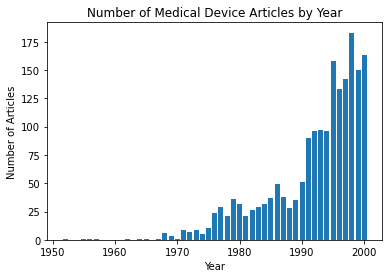

In [9]:
plt.bar(device_pub_year_table.index, [device_pub_year_table.get(x) for x in device_pub_year_table.index])
plt.xlabel("Year")
plt.ylabel("Number of Articles")
plt.title("Number of Medical Device Articles by Year")
plt.show()

### For Export to Voyant Tools

In [10]:
def voyant_export(year_group, dataset_name, start_year, end_year=2000):
    year_title_list = year_group["Title"].unique()
    
    for year in range(start_year, end_year + 1):
        temp_list = []
        try:
            for title in year_title_list[year]:
                title = title.replace("--", " ")
                title = title + "\n"
                temp_list.append(title)
            
            with open("Title Data Files/{a}/{b}_{a}.txt".format(b=year, a=dataset_name), "w") as f:
                f.writelines(temp_list)
       
        except KeyError:  # If there were no publication in a year in the range
            pass
    
    print("Data Exported")

In [ ]:
# voyant_export(year_group = device_date_group, dataset_name="med_dev", start_year=1952, end_year=2000)
# voyant_export(year_group = biomed_date_group, dataset_name="biomed", start_year=1950, end_year=2000)

Medical Device Publication Word Frequency: https://voyant-tools.org/?corpus=fa33b04ff82a6bb8eb2bb7c2b5c9837a&panels=corpusterms,termsberry,trends,summary,contexts

Biomedical Publication Corpus: https://voyant-tools.org/?corpus=d27c6e29211b43ce02d1d96f182704ae

# NetworkX Graph

In [ ]:
with open(file_path, "r") as f:
    full_dict = json.load(f)

In [11]:
G = nx.Graph()

for author in 

,Pubmed ID,Title,Journal,Date
2043,11132200,Importance of temperature and humidity in the ...,Annals of biomedical engineering,2000
2044,11132199,Biphasic material properties of lytic bone met...,Annals of biomedical engineering,2000
2045,11132198,Computer- and robot-assisted total knee replac...,Annals of biomedical engineering,2000
2046,11132197,Stimulated secretion of pituitary hormones in ...,Annals of biomedical engineering,2000
2047,11132196,Respiratory related evoked responses to gradua...,Annals of biomedical engineering,2000
